In [28]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
import os
import zipfile

import cv2
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import pickle
from tqdm.notebook import tqdm

import splitfolders
from tensorflow.keras.applications.resnet import ResNet50
import datetime


In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
base_path = '/content/drive/MyDrive/image_recognition/data/image_data/img/'

In [32]:
with zipfile.ZipFile(base_path + 'conjunctivitis.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

In [33]:
splitfolders.ratio('/content/conjunctivitis', output = 'conjunctivitis_dataset', seed = 77, ratio = (0.8, 0.1, 0.1))

Copying files: 19198 files [00:04, 4662.19 files/s]


## Zero-Centering

In [34]:
train_path = '/content/conjunctivitis_dataset/train'
img_paths = []
for label in os.listdir(train_path):
  sub_path = train_path + '/' + label + '/'
  for files in os.listdir(sub_path):
    img_paths.append(sub_path + files)


In [35]:
X_train = []

for img_file in img_paths:
  img = cv2.imread(img_file)
  X_train.append(img)

In [36]:
compute_mean = lambda imgs: np.mean(imgs, axis = 0)
mean_img = compute_mean(X_train)
sub_mean_img = lambda image: image - mean_img

In [37]:
batch_size = 128

In [43]:
train_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=sub_mean_img)
val_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=sub_mean_img)
test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=sub_mean_img)

In [44]:
train_generator = train_datagen.flow_from_directory('/content/conjunctivitis_dataset/train', batch_size=batch_size, target_size=(224, 224), class_mode = 'binary')
val_generator = val_datagen.flow_from_directory('/content/conjunctivitis_dataset/val', batch_size=batch_size, target_size=(224, 224), class_mode = 'binary')
test_generator = test_datagen.flow_from_directory('/content/conjunctivitis_dataset/test', batch_size=batch_size, target_size=(224, 224), class_mode = 'binary')

Found 15358 images belonging to 2 classes.
Found 1919 images belonging to 2 classes.
Found 1921 images belonging to 2 classes.


In [45]:
base_model_50 = ResNet50(include_top = False, input_shape = (224, 224, 3), weights = 'imagenet')

base_model_50.trainable = True

for layer in base_model_50.layers[:-10]:
  layer.trainable = False

inputs = tf.keras.Input(shape= (224, 224, 3))

x = base_model_50(inputs, training = False)
x = tf.keras.layers.Flatten(input_shape=base_model_50.output_shape[1:])(x)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
s_model_res50_zero = tf.keras.Model(inputs, outputs)

In [46]:
s_model_res50_zero.compile(optimizer='adam', loss= 'binary_crossentropy', metrics = ['accuracy', 'Recall'])

In [49]:
# tensorboard log 저장
model_name = 'conjunctivitis_ZeroCentering'
current_time = datetime.datetime.now().strftime("%m%d%H%M") # Y : 연도 / m : 월 / d : 일 / H : 시 / M : 분 / S : 초
current_time

'03270537'

In [50]:
log_dir = "/content/drive/MyDrive/image_recognition/ayun/logs/ZeroCentering/" + current_time + model_name
board = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=2) # epoch마다 히스토그램 계산
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True) # EarlyStooping , restore_best_weights = True 가장 성능이 좋았을때 

history = s_model_res50_zero.fit(train_generator, validation_data = val_generator, epochs = 100, callbacks=[board, early]) # 콜백 전달

Epoch 1/100
120/120 [==============================] - 61s 502ms/step - loss: 0.1283 - accuracy: 0.9503 - recall: 0.9344 - val_loss: 0.1272 - val_accuracy: 0.9521 - val_recall: 0.9656
Epoch 2/100
120/120 [==============================] - 56s 468ms/step - loss: 0.1138 - accuracy: 0.9574 - recall: 0.9454 - val_loss: 0.0919 - val_accuracy: 0.9620 - val_recall: 0.9343
Epoch 3/100
120/120 [==============================] - 63s 524ms/step - loss: 0.1022 - accuracy: 0.9610 - recall: 0.9486 - val_loss: 0.0862 - val_accuracy: 0.9698 - val_recall: 0.9771
Epoch 4/100
120/120 [==============================] - 57s 476ms/step - loss: 0.1176 - accuracy: 0.9566 - recall: 0.9436 - val_loss: 0.0798 - val_accuracy: 0.9677 - val_recall: 0.9583
Epoch 5/100
120/120 [==============================] - 62s 519ms/step - loss: 0.1058 - accuracy: 0.9616 - recall: 0.9496 - val_loss: 0.1196 - val_accuracy: 0.9578 - val_recall: 0.9823
Epoch 6/100
120/120 [==============================] - 58s 478ms/step - loss: 0.

In [51]:
s_model_res50_zero.evaluate(test_generator)

16/16 [==============================] - 6s 367ms/step - loss: 0.0939 - accuracy: 0.9750 - recall: 0.9657


[0.09392393380403519, 0.975013017654419, 0.9656607508659363]

In [52]:
# 모델 저장 경로 및 파일명 지정
model_path = '/content/drive/MyDrive/image_recognition/js/model/conjunctivitis_zero.h5'

# 모델 저장
s_model_res50_zero.save(model_path)

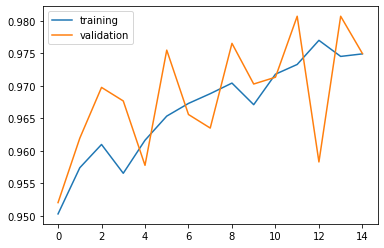

In [53]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

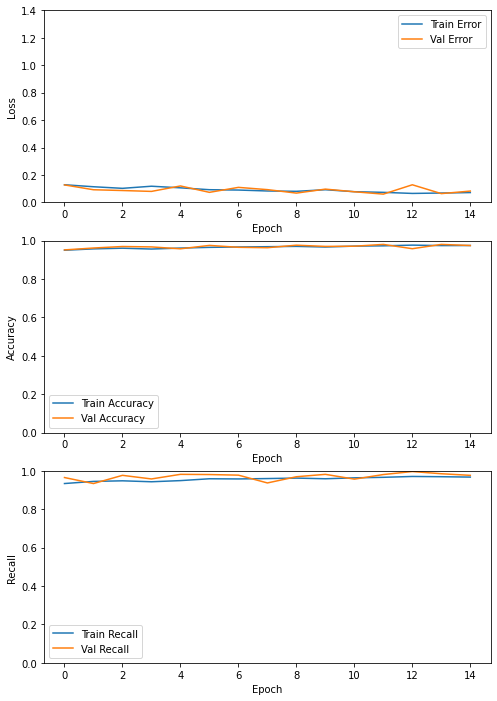

In [54]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(3,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
  plt.ylim([0,1.4])
  plt.legend()
  
  plt.subplot(3,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Accuracy')
  plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Accuracy')
  plt.ylim([0,1])
  plt.legend()

  plt.subplot(3,1,3)
  plt.xlabel('Epoch')
  plt.ylabel('Recall')
  plt.plot(hist['epoch'], hist['recall'],
           label='Train Recall')
  plt.plot(hist['epoch'], hist['val_recall'],
           label = 'Val Recall')
  plt.ylim([0,1])
  plt.legend()
  plt.show()

plot_history(history)